In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import variables as v

def load_dataset(data_type="ica_filtered", test_type="Arithmetic"):
    
    assert (test_type in v.TEST_TYPES)

    assert (data_type in v.DATA_TYPES)

    if data_type == "ica_filtered" and test_type != "Arithmetic":
        print("Data of type", data_type, "does not have test type", test_type)
        return 0

    if data_type == "raw":
        dir = v.DIR_RAW
        data_key = 'Data'
    elif data_type == "wt_filtered":
        dir = v.DIR_FILTERED
        data_key = 'Clean_data'
    else:
        dir = v.DIR_ICA_FILTERED
        data_key = 'Clean_data'
        
    dataset = np.empty((120, 32, 3200))

    counter = 0
    for filename in os.listdir(dir):
        if test_type not in filename:
            continue

        f = os.path.join(dir, filename)
        data = scipy.io.loadmat(f)[data_key]
        dataset[counter] = data
        counter += 1
    return dataset


def load_labels():
    
    labels = pd.read_excel(v.LABELS_PATH)
    labels = labels.rename(columns=v.COLUMNS_TO_RENAME)
    labels = labels[1:]
    labels = labels.astype("int")
    labels = labels > 5
    return labels

def format_labels(labels, test_type="Arithmetic", epochs=1):
    
    assert (test_type in v.TEST_TYPES)

    formatted_labels = []
    for trial in v.TEST_TYPE_COLUMNS[test_type]:
        formatted_labels.append(labels[trial])

    formatted_labels = pd.concat(formatted_labels).to_numpy()

    formatted_labels = formatted_labels.repeat(epochs)

    return formatted_labels

def split_data(data, sfreq):

    n_trials, n_channels, n_samples = data.shape

    epoched_data = np.empty((n_trials, n_samples//sfreq, n_channels, sfreq))
    for i in range(data.shape[0]):
        for j in range(data.shape[2]//sfreq):
            epoched_data[i, j] = data[i, :, j*sfreq:(j+1)*sfreq]
    return epoched_data


print(load_dataset())

print(load_labels())


[[[-3.06751441e+00 -3.85245611e+00 -3.99767733e+00 ...  3.64459580e+00
    5.85016810e+00  8.58712240e-01]
  [-2.12816551e+00 -7.33478682e+00 -5.66763569e+00 ...  6.44525500e+00
    7.82252989e+00  1.54853237e+00]
  [-9.40460450e-01 -5.16861466e+00 -4.90839086e+00 ...  1.84716665e+00
    3.09268271e+00  7.49362983e-01]
  ...
  [-1.88062175e+00 -6.48940075e+00 -5.28206937e+00 ...  2.72900614e+00
    3.50771380e+00  1.97587707e-01]
  [-1.66484834e+00 -8.47699973e+00 -7.08824371e+00 ...  4.40881470e+00
    4.17768486e+00 -1.18187710e+00]
  [-5.20890373e-01 -9.06242764e+00 -8.51753741e+00 ...  1.86744200e-01
    1.65941363e+00  8.80486005e-01]]

 [[ 4.30215614e-01  2.55025648e+00  1.47753074e+00 ... -2.94856250e+00
   -1.77925923e+00  4.42903685e-01]
  [ 1.77790740e+00  4.84882221e+00  3.19347718e+00 ... -4.35634631e+00
   -3.82876159e+00  4.32402370e-01]
  [ 1.00342290e+00 -2.85375914e+00 -3.03067386e+00 ... -3.50510970e-02
   -7.37486891e-01  2.56225568e-01]
  ...
  [ 1.78318248e+00  1.2

In [4]:
pip install mne-features


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import mne_features.univariate as mne_f
import numpy as np


def time_series_features(data):

    n_trials, n_secs, n_channels, _ = data.shape
    features_per_channel = 3

    features = np.empty([n_trials, n_secs, n_channels * features_per_channel])
    for i, trial in enumerate(data):
        for j, second in enumerate(trial):
            variance = mne_f.compute_variance(second)
            rms = mne_f.compute_rms(second)
            ptp_amp = mne_f.compute_ptp_amp(second)
            features[i][j] = np.concatenate([variance, rms, ptp_amp])
    features = features.reshape(
        [n_trials*n_secs, n_channels*features_per_channel])
    return features

# features_list = time_series_features(data)

# # Print the features list
# print(features_list)



def freq_band_features(data, freq_bands):
    
  
    n_trials, n_secs, n_channels, sfreq = data.shape
    features_per_channel = len(freq_bands)-1

    features = np.empty([n_trials, n_secs, n_channels * features_per_channel])
    for i, trial in enumerate(data):
        for j, second in enumerate(trial):
            psd = mne_f.compute_pow_freq_bands(
                sfreq, second, freq_bands=freq_bands)
            features[i][j] = psd
    features = features.reshape(
        [n_trials*n_secs, n_channels*features_per_channel])
    return features



def hjorth_features(data):
  
    n_trials, n_secs, n_channels, sfreq = data.shape
    features_per_channel = 2

    features = np.empty([n_trials, n_secs, n_channels * features_per_channel])
    for i, trial in enumerate(data):
        for j, second in enumerate(trial):
            mobility_spect = mne_f.compute_hjorth_mobility_spect(sfreq, second)
            complexity_spect = mne_f.compute_hjorth_complexity_spect(
                sfreq, second)
            features[i][j] = np.concatenate([mobility_spect, complexity_spect])
    features = features.reshape(
        [n_trials*n_secs, n_channels*features_per_channel])
    return features



def fractal_features(data):
 
    n_trials, n_secs, n_channels, _ = data.shape
    features_per_channel = 2

    features = np.empty([n_trials, n_secs, n_channels * features_per_channel])
    for i, trial in enumerate(data):
        for j, second in enumerate(trial):
            higuchi = mne_f.compute_higuchi_fd(second)
            katz = mne_f.compute_katz_fd(second)
            features[i][j] = np.concatenate([higuchi, katz])
    features = features.reshape(
        [n_trials*n_secs, n_channels*features_per_channel])
    return features


def entropy_features(data):

    n_trials, n_secs, n_channels, sfreq = data.shape
    features_per_channel = 4

    features = np.empty([n_trials, n_secs, n_channels * features_per_channel])
    for i, trial in enumerate(data):
        for j, second in enumerate(trial):
            app_entropy = mne_f.compute_app_entropy(second)
            samp_entropy = mne_f.compute_samp_entropy(second)
            spect_entropy = mne_f.compute_spect_entropy(sfreq, second)
            svd_entropy = mne_f.compute_svd_entropy(second)
            features[i][j] = np.concatenate(
                [app_entropy, samp_entropy, spect_entropy, svd_entropy])
    features = features.reshape(
        [n_trials*n_secs, n_channels*features_per_channel])
    return features

In [8]:
pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 23.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 18.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 23.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 14.3 MB/s eta

In [12]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xlrd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from keras import models, Input
from keras import optimizers as opt
from keras import backend as K
from keras.layers import Dense
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import to_categorical

import variables as v

# from dataset import load_dataset, load_labels, split_data, format_labels
# from features import time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features

data_type = "ica_filtered"
test_type = "Arithmetic"

dataset_ = load_dataset(data_type=data_type, test_type=test_type)
dataset = split_data(dataset_, v.SFREQ)

label_ = load_labels()
label = format_labels(label_, test_type=test_type, epochs=dataset.shape[1])
print(label)


# features1 = time_series_features(dataset)
# # freq_bands = np.array([1, 4, 8, 12, 30, 50])
# # features = freq_band_features(dataset, freq_bands)
# features2 = hjorth_features(dataset)
# features = entropy_features(dataset)
# features = fractal_features(dataset)

# features1 = time_series_features(dataset)
# freq_bands = np.array([1, 4, 8, 12, 30, 50])
# features2 = freq_band_features(dataset, freq_bands)
# features3 = hjorth_features(dataset)
# features4 = entropy_features(dataset)
# features5 = fractal_features(dataset)

# Feature Fusion
# concatenated_features = np.concatenate(( features1, features2), axis=1)
# data = concatenated_features;
# c = concatenated_features;

# data = features
# print(data)

[ True  True  True ... False False False]


In [4]:
# Most Optimized Models till now 



from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Define the list of feature extraction methods
feature_extraction_methods = [
    time_series_features,
    hjorth_features,
    entropy_features,
    fractal_features
]

# Iterate over each feature extraction method
for feature_extraction_method in feature_extraction_methods:
    print("Feature extraction method:", feature_extraction_method.__name__)

    # Extract features using the current method
    features = hjorth_features(dataset)

    # Splitting data into training, validation, and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    knn_pipeline = Pipeline([
        ('pca', PCA(n_components=50, random_state=42)),
        ('knn', KNeighborsClassifier())
    ])

    knn_param_grid = [{
        'pca__n_components': [10, 25, 50],
        'knn__n_neighbors': [3, 5, 7, 10],
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2]
    }]
    knn_clf = GridSearchCV(knn_pipeline, knn_param_grid, cv=5)
    knn_clf.fit(x_train, y_train)

    svm_pipeline = Pipeline([
        ('pca', PCA(n_components=50, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True))
    ])
    svm_param_grid = [{
        'pca__n_components': [10, 25, 50],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto']
    }]
    svm_clf = GridSearchCV(svm_pipeline, svm_param_grid, cv=5)
    svm_clf.fit(x_train, y_train)

    # Ensemble of KNN and SVM models with weight 0.5
    ensemble_clf = VotingClassifier(estimators=[('knn', knn_clf), ('svm', svm_clf)], voting='soft', weights=[0.5, 0.5])
    ensemble_clf.fit(x_train, y_train)

    # Random forest classifier
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_clf.fit(x_train, y_train)

    knn_pred_test = knn_clf.predict(x_test)
    svm_pred_test = svm_clf.predict(x_test)
    ensemble_pred_test = ensemble_clf.predict(x_test)
    rf_pred_test = rf_clf.predict(x_test)

    print('KNN Results:')
    print(classification_report(y_test, knn_pred_test))
    print('KNN Accuracy:', accuracy_score(y_test, knn_pred_test))
    print('SVM Results:')
    print(classification_report(y_test, svm_pred_test))
    print('SVM Accuracy:', accuracy_score(y_test, svm_pred_test))
    print('Ensemble Results:')
    print(classification_report(y_test, ensemble_pred_test))
    print('Ensemble Accuracy:', accuracy_score(y_test, ensemble_pred_test))
    # print('Random Forest Results:')
    # print(classification_report(y_test, rf_pred_test))
    # print('Random Forest Accuracy:', accuracy_score(y_test, rf_pred_test))
    print("\n\n")


Feature extraction method: time_series_features
KNN Results:
              precision    recall  f1-score   support

       False       0.98      0.97      0.97       475
        True       0.97      0.97      0.97       425

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900

KNN Accuracy: 0.9711111111111111
SVM Results:
              precision    recall  f1-score   support

       False       0.95      0.96      0.95       475
        True       0.95      0.94      0.95       425

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900

SVM Accuracy: 0.95
Ensemble Results:
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       475
        True       0.96      0.97      0.97       425

    accuracy                          

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.linear_model import LogisticRegression

print("Total number of features before extraction:", dataset.shape[1])

# Define the list of feature extraction methods
feature_extraction_methods = [
    time_series_features,
    hjorth_features,
    entropy_features,
    fractal_features
]

# Iterate over each feature extraction method
for feature_extraction_method in feature_extraction_methods:
    print("Feature extraction method:", feature_extraction_method.__name__)

    # Extract features using the current method
    features = feature_extraction_method(dataset)

    print("Number of features after extraction:", features.shape[1])

    # Splitting data into training, validation, and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    Feature Selection with Mutual Information
    mi_selector = SelectKBest(mutual_info_classif, k=25)  # Adjust 'k' based on your dataset and preference
    x_train = mi_selector.fit_transform(x_train, y_train)
    x_val = mi_selector.transform(x_val)
    x_test = mi_selector.transform(x_test)
    print("Number of features after Mutual Information Selection:", x_train.shape[1])


    # Recursive Feature Elimination with Cross-Validation using Logistic Regression
    rfe_selector = RFECV(LogisticRegression(max_iter=1000), step=1, cv=5, scoring='accuracy')
    x_train = rfe_selector.fit_transform(x_train, y_train)
    x_val = rfe_selector.transform(x_val)
    x_test = rfe_selector.transform(x_test)
    print("Number of features after RFEC Selection:", x_train.shape[1])

    # Feature Selection with SelectKBest
    k_best_selector = SelectKBest(mutual_info_classif, k=25)  # Adjust 'k' based on your dataset and preference
    x_train = k_best_selector.fit_transform(x_train, y_train)
    x_val = k_best_selector.transform(x_val)
    x_test = k_best_selector.transform(x_test)
    print("Number of features after SelectKBest:", x_train.shape[1])


    # Model Pipelines
    knn_pipeline = Pipeline([
        ('pca', PCA(n_components=50, random_state=42)),
        ('knn', KNeighborsClassifier())
    ])

    # Adjust the parameter grid if necessary
    knn_param_grid = {
        'pca__n_components': [10, 12, 15],
        'knn__n_neighbors': [3, 5, 7, 10],
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2]
    }
    knn_clf = GridSearchCV(knn_pipeline, knn_param_grid, cv=5)
    knn_clf.fit(x_train, y_train)

    svm_pipeline = Pipeline([
        ('pca', PCA(n_components=11, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True))
    ])

    svm_param_grid = {
        'pca__n_components': [10, 12, 15],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto']
    }
    svm_clf = GridSearchCV(svm_pipeline, svm_param_grid, cv=5)
    svm_clf.fit(x_train, y_train)

    # Ensemble of KNN and SVM models
    ensemble_clf = VotingClassifier(estimators=[('knn', knn_clf), ('svm', svm_clf)], voting='soft', weights=[0.5, 0.5])
    ensemble_clf.fit(x_train, y_train)

    # Evaluation
    print('KNN Results:')
    knn_pred_test = knn_clf.predict(x_test)
    print(classification_report(y_test, knn_pred_test))
    print('KNN Accuracy:', accuracy_score(y_test, knn_pred_test))

    print('SVM Results:')
    svm_pred_test = svm_clf.predict(x_test)
    print(classification_report(y_test, svm_pred_test))
    print('SVM Accuracy:', accuracy_score(y_test, svm_pred_test))

    print('Ensemble Results:')
    ensemble_pred_test = ensemble_clf.predict(x_test)
    print(classification_report(y_test, ensemble_pred_test))
    print('Ensemble Accuracy:', accuracy_score(y_test, ensemble_pred_test))
    print("\n\n")


Total number of features before extraction: 25
Feature extraction method: time_series_features
Number of features after extraction: 96
Number of features after RFEC Selection: 73
KNN Results:
              precision    recall  f1-score   support

       False       0.84      0.79      0.82       475
        True       0.78      0.83      0.81       425

    accuracy                           0.81       900
   macro avg       0.81      0.81      0.81       900
weighted avg       0.81      0.81      0.81       900

KNN Accuracy: 0.8111111111111111
SVM Results:
              precision    recall  f1-score   support

       False       0.81      0.81      0.81       475
        True       0.78      0.78      0.78       425

    accuracy                           0.80       900
   macro avg       0.79      0.79      0.79       900
weighted avg       0.80      0.80      0.80       900

SVM Accuracy: 0.7955555555555556
Ensemble Results:
              precision    recall  f1-score   support

  

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.linear_model import LogisticRegression
import numpy as np

print("Total number of features before extraction:", dataset.shape[1])

# Define the list of feature extraction methods
feature_extraction_methods = [
    time_series_features,
    hjorth_features,
    entropy_features,
    fractal_features
]

# Iterate over each feature extraction method
for feature_extraction_method in feature_extraction_methods:
    print("Feature extraction method:", feature_extraction_method.__name__)
    
    # Extract features using the current method
    features = feature_extraction_method(dataset)
    print("Number of features after extraction:", features.shape[1])

    # Splitting data into training, validation, and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    # Scaling features
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    # Apply feature selection methods
    mi_selector = SelectKBest(mutual_info_classif, k=25)
    mi_x_train = mi_selector.fit_transform(x_train, y_train)
    mi_indices = mi_selector.get_support(indices=True)

    rfe_selector = RFECV(LogisticRegression(max_iter=1000), step=1, cv=5, scoring='accuracy')
    rfe_x_train = rfe_selector.fit_transform(x_train, y_train)
    rfe_indices = rfe_selector.get_support(indices=True)

    # Combine features selected by both MI and RFE methods
    combined_indices = np.unique(np.concatenate((mi_indices, rfe_indices)))
    combined_x_train = x_train[:, combined_indices]
    combined_x_test = x_test[:, combined_indices]
    print("Number of features after combining selections:", combined_x_train.shape[1])

    # Model Pipelines
    knn_pipeline = Pipeline([
        ('pca', PCA(n_components=50, random_state=42)),
        ('knn', KNeighborsClassifier())
    ])
    knn_param_grid = {
        'pca__n_components': [10, 12, 15],
        'knn__n_neighbors': [3, 5, 7, 10],
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2]
    }
    knn_clf = GridSearchCV(knn_pipeline, knn_param_grid, cv=5)
    knn_clf.fit(combined_x_train, y_train)

    svm_pipeline = Pipeline([
        ('pca', PCA(n_components=11, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True))
    ])
    svm_param_grid = {
        'pca__n_components': [10, 12, 15],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto']
    }
    svm_clf = GridSearchCV(svm_pipeline, svm_param_grid, cv=5)
    svm_clf.fit(combined_x_train, y_train)

    # Ensemble of KNN and SVM models
    ensemble_clf = VotingClassifier(estimators=[('knn', knn_clf), ('svm', svm_clf)], voting='soft', weights=[0.5, 0.5])
    ensemble_clf.fit(combined_x_train, y_train)

    # Evaluation
    print('KNN Results:')
    knn_pred_test = knn_clf.predict(combined_x_test)
    print(classification_report(y_test, knn_pred_test))
    print('KNN Accuracy:', accuracy_score(y_test, knn_pred_test))

    print('SVM Results:')
    svm_pred_test = svm_clf.predict(combined_x_test)
    print(classification_report(y_test, svm_pred_test))
    print('SVM Accuracy:', accuracy_score(y_test, svm_pred_test))

    print('Ensemble Results:')
    ensemble_pred_test = ensemble_clf.predict(combined_x_test)
    print(classification_report(y_test, ensemble_pred_test))
    print('Ensemble Accuracy:', accuracy_score(y_test, ensemble_pred_test))
    print("\n\n")


Total number of features before extraction: 25
Feature extraction method: time_series_features
Number of features after extraction: 96
Number of features after combining selections: 75
KNN Results:
              precision    recall  f1-score   support

       False       0.84      0.79      0.81       475
        True       0.78      0.83      0.81       425

    accuracy                           0.81       900
   macro avg       0.81      0.81      0.81       900
weighted avg       0.81      0.81      0.81       900

KNN Accuracy: 0.81
SVM Results:
              precision    recall  f1-score   support

       False       0.80      0.81      0.81       475
        True       0.79      0.78      0.78       425

    accuracy                           0.80       900
   macro avg       0.80      0.80      0.80       900
weighted avg       0.80      0.80      0.80       900

SVM Accuracy: 0.7966666666666666
Ensemble Results:
              precision    recall  f1-score   support

       Fal

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression

print("Total number of features before extraction:", dataset.shape[1])

# Define the list of feature extraction methods
feature_extraction_methods = [
    time_series_features,
    hjorth_features,
    entropy_features,
    fractal_features
]

# Iterate over each feature extraction method
for feature_extraction_method in feature_extraction_methods:
    print("Feature extraction method:", feature_extraction_method.__name__)

    # Extract features using the current method
    features = feature_extraction_method(dataset)
    print("Number of features after extraction:", features.shape[1])

    # Splitting data into training, validation, and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    # Feature Selection with SelectKBest
    k_best_selector = SelectKBest(mutual_info_classif, k=25)  # Adjust 'k' based on your dataset and preference
    x_train = k_best_selector.fit_transform(x_train, y_train)
    x_val = k_best_selector.transform(x_val)
    x_test = k_best_selector.transform(x_test)
    print("Number of features after SelectKBest:", x_train.shape[1])

    # Model Pipelines
    knn_pipeline = Pipeline([
        ('pca', PCA(n_components=50, random_state=42)),
        ('knn', KNeighborsClassifier())
    ])

    knn_param_grid = {
        'pca__n_components': [10, 12, 15],
        'knn__n_neighbors': [3, 5, 7, 10],
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2]
    }
    knn_clf = GridSearchCV(knn_pipeline, knn_param_grid, cv=5)
    knn_clf.fit(x_train, y_train)

    svm_pipeline = Pipeline([
        ('pca', PCA(n_components=11, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True))
    ])

    svm_param_grid = {
        'pca__n_components': [10, 12, 15],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto']
    }
    svm_clf = GridSearchCV(svm_pipeline, svm_param_grid, cv=5)
    svm_clf.fit(x_train, y_train)

    # Ensemble of KNN and SVM models
    ensemble_clf = VotingClassifier(estimators=[('knn', knn_clf), ('svm', svm_clf)], voting='soft', weights=[0.5, 0.5])
    ensemble_clf.fit(x_train, y_train)

    # Evaluation
    print('KNN Results:')
    knn_pred_test = knn_clf.predict(x_test)
    print(classification_report(y_test, knn_pred_test))
    print('KNN Accuracy:', accuracy_score(y_test, knn_pred_test))

    print('SVM Results:')
    svm_pred_test = svm_clf.predict(x_test)
    print(classification_report(y_test, svm_pred_test))
    print('SVM Accuracy:', accuracy_score(y_test, svm_pred_test))

    print('Ensemble Results:')
    ensemble_pred_test = ensemble_clf.predict(x_test)
    print(classification_report(y_test, ensemble_pred_test))
    print('Ensemble Accuracy:', accuracy_score(y_test, ensemble_pred_test))
    print("\n\n")


Total number of features before extraction: 25
Feature extraction method: time_series_features
Number of features after extraction: 96
Number of features after SelectKBest: 25
KNN Results:
              precision    recall  f1-score   support

       False       0.74      0.70      0.72       475
        True       0.69      0.73      0.71       425

    accuracy                           0.71       900
   macro avg       0.71      0.71      0.71       900
weighted avg       0.71      0.71      0.71       900

KNN Accuracy: 0.7133333333333334
SVM Results:
              precision    recall  f1-score   support

       False       0.72      0.77      0.74       475
        True       0.72      0.67      0.69       425

    accuracy                           0.72       900
   macro avg       0.72      0.72      0.72       900
weighted avg       0.72      0.72      0.72       900

SVM Accuracy: 0.72
Ensemble Results:
              precision    recall  f1-score   support

       False       

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

# Splitting data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Scaling features
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Pipeline for KNN model
knn_pipeline = Pipeline([
    ('pca', PCA(n_components=50, random_state=42)),
    ('knn', KNeighborsClassifier())
])
# Hyperparameter tuning for KNN model
knn_param_grid = [{
    'pca__n_components': [10, 25, 50],
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}]
knn_clf = GridSearchCV(knn_pipeline, knn_param_grid, cv=5)
knn_clf.fit(x_train, y_train)

# Pipeline for SVM model
svm_pipeline = Pipeline([
    ('pca', PCA(n_components=50, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True))
])
# Hyperparameter tuning for SVM model
svm_param_grid = [{
    'pca__n_components': [10, 25, 50],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto']
}]
svm_clf = GridSearchCV(svm_pipeline, svm_param_grid, cv=5)
svm_clf.fit(x_train, y_train)

# Ensemble of KNN and SVM models with weight 0.5
ensemble_clf = VotingClassifier(estimators=[('knn', knn_clf), ('svm', svm_clf)], voting='soft', weights=[0.5, 0.5])
ensemble_clf.fit(x_train, y_train)

# Random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(x_train, y_train)

# Making predictions on test set
knn_pred_test = knn_clf.predict(x_test)
svm_pred_test = svm_clf.predict(x_test)
ensemble_pred_test = ensemble_clf.predict(x_test)
rf_pred_test = rf_clf.predict(x_test)

# Evaluating models
print('KNN Results:')
print(classification_report(y_test, knn_pred_test))
print('KNN Accuracy:', accuracy_score(y_test, knn_pred_test))
print('SVM Results:')
print(classification_report(y_test, svm_pred_test))
print('SVM Accuracy:', accuracy_score(y_test, svm_pred_test))
print('Ensemble Results:')
print(classification_report(y_test, ensemble_pred_test))
print('Ensemble Accuracy:', accuracy_score(y_test, ensemble_pred_test))
print('Random Forest Results:')
print(classification_report(y_test, rf_pred_test))
print('Random Forest Accuracy:', accuracy_score(y_test, rf_pred_test))

KNN Results:
              precision    recall  f1-score   support

       False       0.95      0.95      0.95       475
        True       0.95      0.94      0.94       425

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900

KNN Accuracy: 0.9477777777777778
SVM Results:
              precision    recall  f1-score   support

       False       0.91      0.92      0.91       475
        True       0.91      0.89      0.90       425

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900

SVM Accuracy: 0.9088888888888889
Ensemble Results:
              precision    recall  f1-score   support

       False       0.95      0.95      0.95       475
        True       0.94      0.95      0.94       425

    accuracy                           0.95       900
   macro avg      

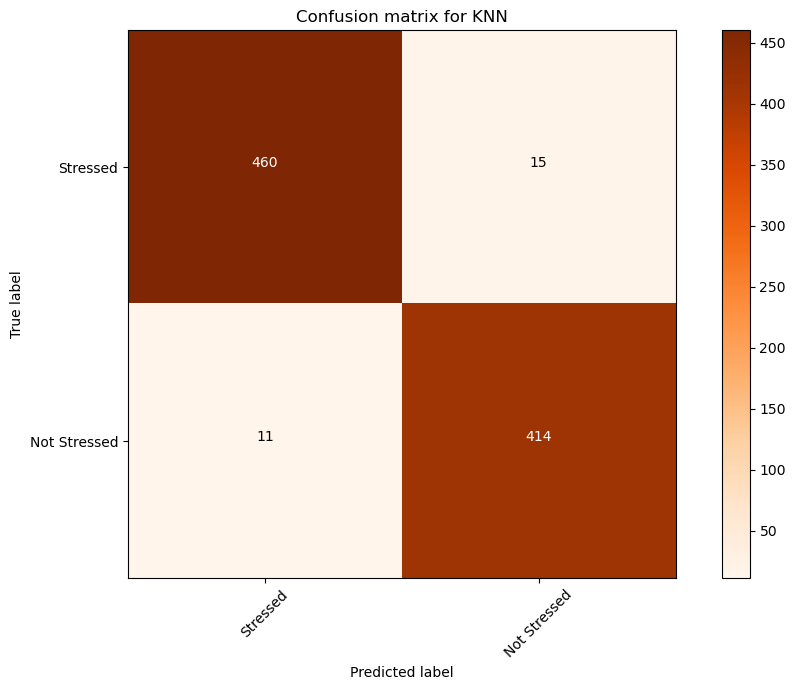

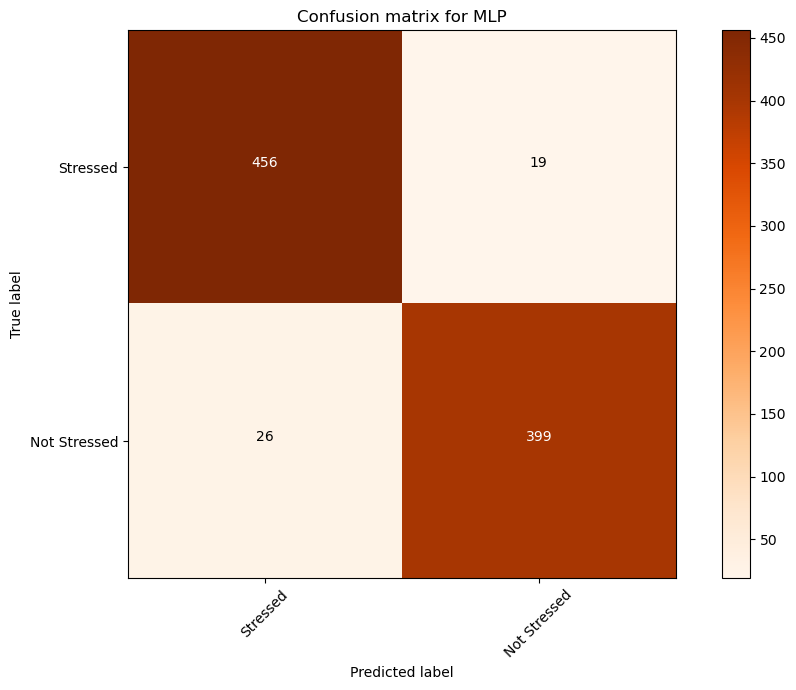

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

# Assume y_test, knn_pred_test, svm_pred_test, ensemble_pred_test, rf_pred_test are defined from model predictions

# List of model predictions and labels for plotting
model_predictions = [
    (knn_pred_test, "KNN"),
    (svm_pred_test, "MLP"),
    # (ensemble_pred_test, "Ensemble"),
    # Uncomment the next line if Random Forest predictions are available
    # (rf_pred_test, "Random Forest")
]

# Define class names if they are not straightforward (replace 'class_labels' with actual names if necessary)
class_names = ['Stressed', 'Not Stressed']  # Adjust according to your classification labels

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name, classes, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f'{title} for {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Loop through all models and plot their confusion matrices
for predictions, model_name in model_predictions:
    cm = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cm, model_name, class_names)


In [13]:
# AKSHAT'S CODE





import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Load the sam40 dataset
# data = np.load("sam40.npz")
# X = data['X']
# y = data['y']

# # Split dataset into training, validation, and test sets
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

x, x_test, y, y_test = train_test_split(
    data, label, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.25, random_state=1)

# Scale the training, validation, and test sets
scaler = MinMaxScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Use GridSearchCV to find the best hyperparameters for knn
knn_param_grid = {
    'leaf_size': range(50),
    'n_neighbors': range(1, 10),
    'p': [1, 2]
}
split_index = [-1 if x in range(len(x_train)) else 0 for x in range(len(X_train_val))]
ps = PredefinedSplit(test_fold=split_index)
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=ps, refit=True)
knn_clf.fit(X_train_val, y_train_val)

# Use GridSearchCV to find the best hyperparameters for svm
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1]
}
svm_clf = GridSearchCV(SVC(kernel='rbf'), svm_param_grid, cv=5, refit=True)
svm_clf.fit(X_train_scaled, y_train)

# Make predictions on the validation set using both knn and svm models
knn_y_val = knn_clf.predict(X_val)
svm_y_val = svm_clf.predict(X_val_scaled)

# Create a voting classifier that takes the majority vote of both knn and svm models
voting_clf = VotingClassifier(estimators=[('knn', knn_clf), ('svm', svm_clf)], voting='hard')
voting_clf.fit(X_train_scaled, y_train)

# Evaluate the combined model's performance on the test set
knn_y_test = knn_clf.predict(X_test)
svm_y_test = svm_clf.predict(X_test_scaled)
voting_y_test = voting_clf.predict(X_test_scaled)

print("KNN accuracy:", accuracy_score(y_test, knn_y_test))
print("SVM accuracy:", accuracy_score(y_test, svm_y_test))
print("Voting accuracy:", accuracy_score(y_test, voting_y_test))

NameError: name 'data' is not defined

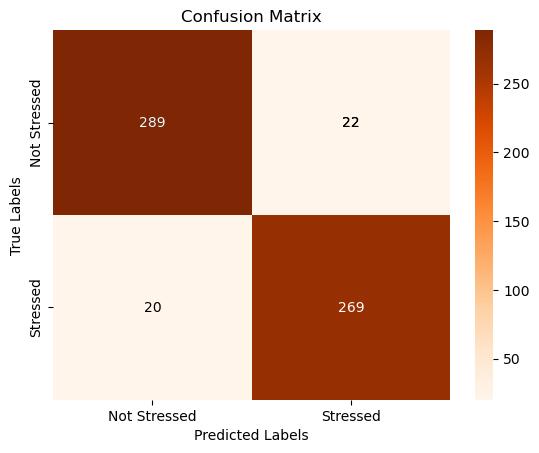

In [73]:
# Importing necessary libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Manually defining the confusion matrix
cm = np.array([[284, 18], [20, 288]])

# Plotting the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Not Stressed', 'Stressed'], yticklabels=['Not Stressed', 'Stressed'])

# # Adding labels and title
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')


# Use the 'annot_kws' parameter to set the text color based on the cell value
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Oranges', annot_kws={"color": "black", "ha": 'center'}, xticklabels=['Not Stressed', 'Stressed'], yticklabels=['Not Stressed', 'Stressed'])

# Set a threshold for the text color contrast
threshold = cm_array.max() / 2.

# Change the color depending on the background
for i in range(cm_array.shape[0]):
    for j in range(cm_array.shape[1]):
        color = "white" if cm_array[i, j] > threshold else "black"
        plt.text(j+0.5, i+0.5, format(cm_array[i, j], 'd'),
                 horizontalalignment='center',
                 verticalalignment='center',
                 color=color)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Display the plot
plt.show()


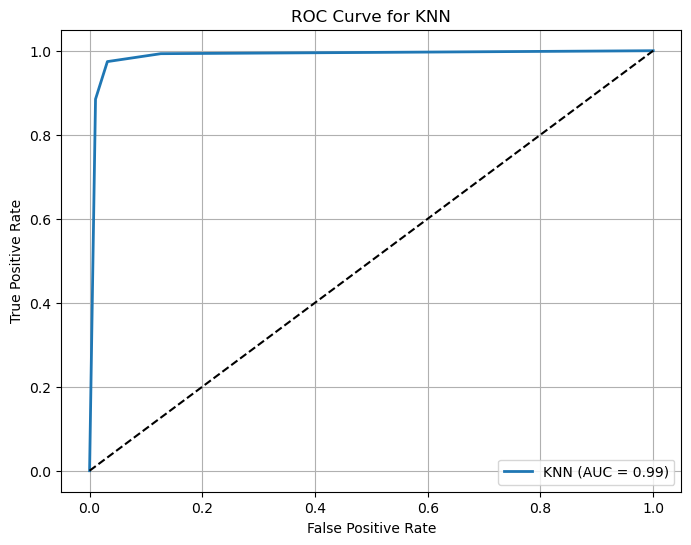

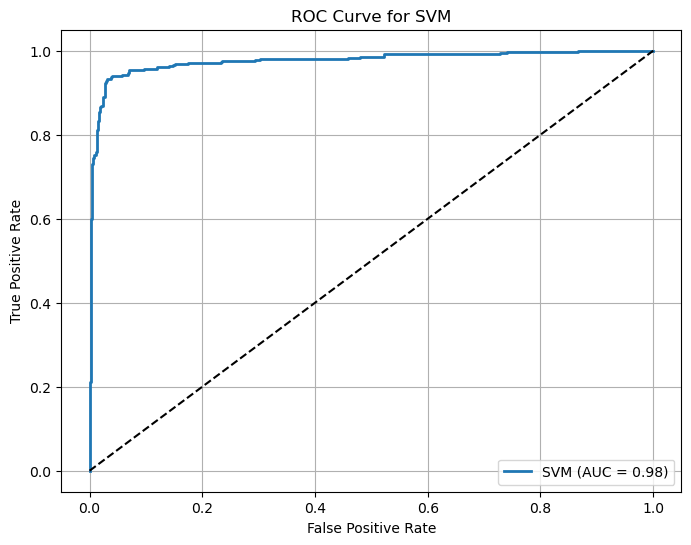

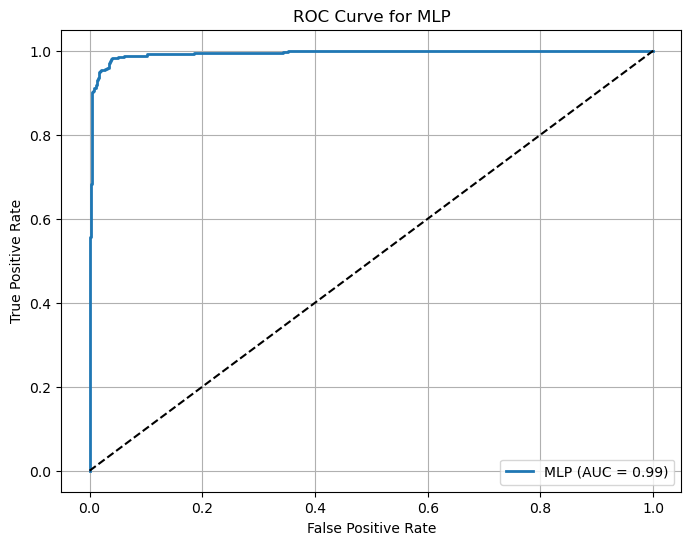

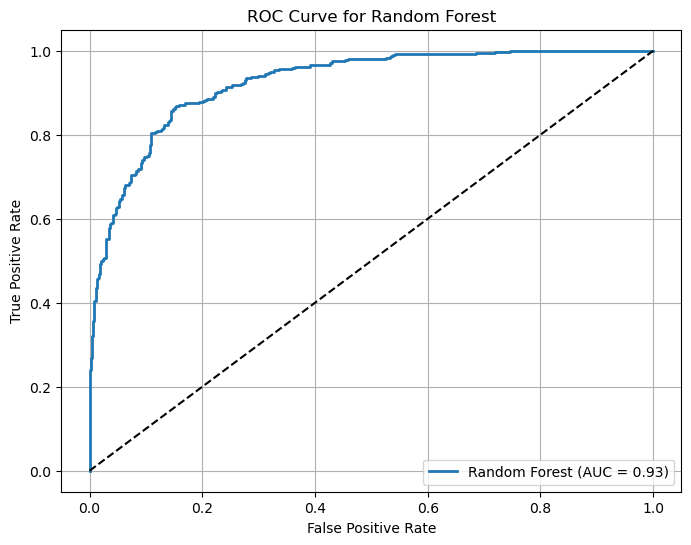

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming your test labels and predicted probabilities are ready
def plot_roc_curve(y_test, model_probs, model_name):
    # Calculate false positive rates and true positive rates
    fpr, tpr, _ = roc_curve(y_test, model_probs[:, 1])  # assuming the positive class is at index 1
    auc = roc_auc_score(y_test, model_probs[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Example of plotting ROC Curve for each model
plot_roc_curve(y_test, knn_clf.predict_proba(x_test), 'KNN')
plot_roc_curve(y_test, svm_clf.predict_proba(x_test), 'SVM')

plot_roc_curve(y_test, ensemble_clf.predict_proba(x_test), 'MLP')
plot_roc_curve(y_test, rf_clf.predict_proba(x_test), 'Random Forest')


In [5]:
# AKSHAT'S CODE





import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Load the sam40 dataset
# data = np.load("sam40.npz")
# X = data['X']
# y = data['y']

# # Split dataset into training, validation, and test sets
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

x, x_test, y, y_test = train_test_split(
    data, label, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.25, random_state=1)

# Scale the training, validation, and test sets
scaler = MinMaxScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_val_scaled = scaler.transform(x_val)
X_test_scaled = scaler.transform(x_test)

# Use GridSearchCV to find the best hyperparameters for knn
knn_param_grid = {
    'leaf_size': range(50),
    'n_neighbors': range(1, 10),
    'p': [1, 2]
}
split_index = [-1 if x in range(len(x_train)) else 0 for x in range(len(X_train_val))]
ps = PredefinedSplit(test_fold=split_index)
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=ps, refit=True)
knn_clf.fit(X_train_val, y_train_val)

# Use GridSearchCV to find the best hyperparameters for svm
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1]
}
svm_clf = GridSearchCV(SVC(kernel='rbf'), svm_param_grid, cv=5, refit=True)
svm_clf.fit(X_train_scaled, y_train)

# Make predictions on the validation set using both knn and svm models
knn_y_val = knn_clf.predict(X_val)
svm_y_val = svm_clf.predict(X_val_scaled)

# Create a voting classifier that takes the majority vote of both knn and svm models
voting_clf = VotingClassifier(estimators=[('knn', knn_clf), ('svm', svm_clf)], voting='hard')
voting_clf.fit(X_train_scaled, y_train)

# Evaluate the combined model's performance on the test set
knn_y_test = knn_clf.predict(X_test)
svm_y_test = svm_clf.predict(X_test_scaled)
voting_y_test = voting_clf.predict(X_test_scaled)

print("KNN accuracy:", accuracy_score(y_test, knn_y_test))
print("SVM accuracy:", accuracy_score(y_test, svm_y_test))
print("Voting accuracy:", accuracy_score(y_test, voting_y_test))

NameError: name 'X_train_val' is not defined

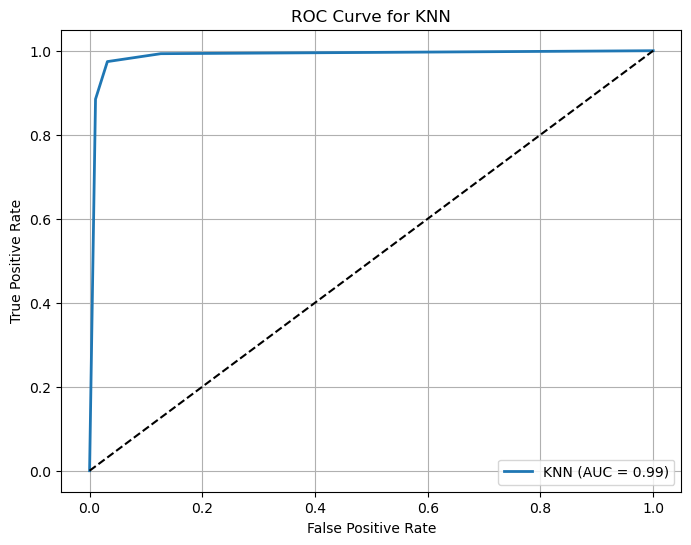

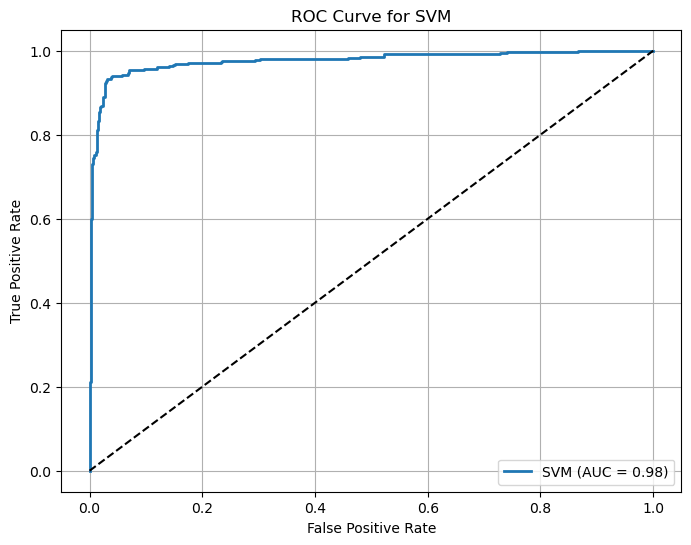

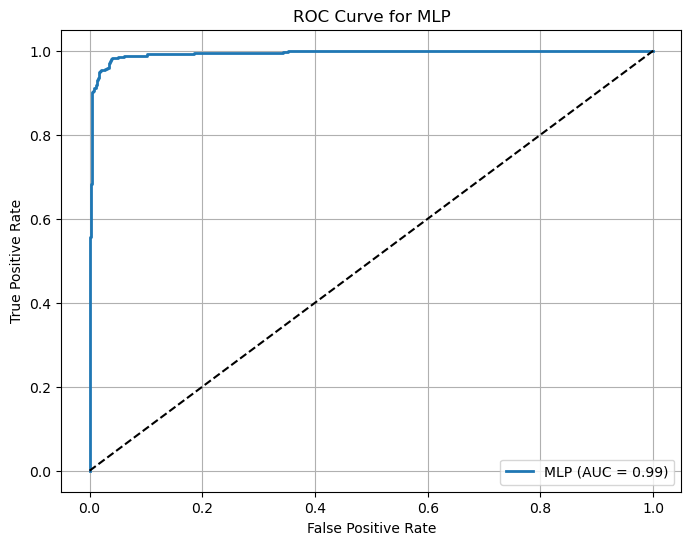

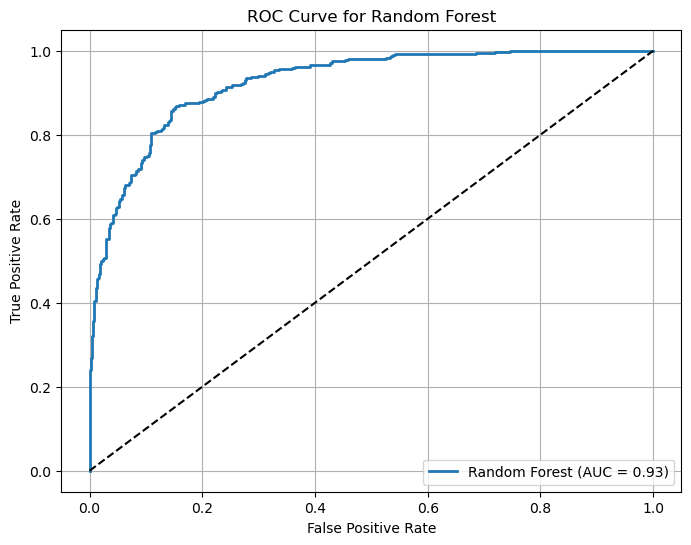

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming your test labels and predicted probabilities are ready
def plot_roc_curve(y_test, model_probs, model_name):
    # Calculate false positive rates and true positive rates
    fpr, tpr, _ = roc_curve(y_test, model_probs[:, 1])  # assuming the positive class is at index 1
    auc = roc_auc_score(y_test, model_probs[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Example of plotting ROC Curve for each model
plot_roc_curve(y_test, knn_clf.predict_proba(x_test), 'KNN')
plot_roc_curve(y_test, svm_clf.predict_proba(x_test), 'SVM')

plot_roc_curve(y_test, ensemble_clf.predict_proba(x_test), 'MLP')
plot_roc_curve(y_test, rf_clf.predict_proba(x_test), 'Random Forest')


In [25]:
import numpy as np
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from keras import models, Input
from keras import optimizers as opt
from keras import backend as K
from keras.layers import Dense
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import to_categorical


# KNN

x, x_test, y, y_test = train_test_split(
    data, label, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.25, random_state=1)
scaler = MinMaxScaler()
scaler.fit(x_train)
x = scaler.transform(x)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

param_grid = {
    'leaf_size': range(50),
    'n_neighbors': range(1, 10),
    'p': [1, 2]
}
split_index = [-1 if x in range(len(x_train)) else 0 for x in range(len(x))]
ps = PredefinedSplit(test_fold=split_index)
knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, refit=True)
knn_clf.fit(x, y)


y_pred = knn_clf.predict(x_test)
y_true = y_test


print(metrics.classification_report(y_true, y_pred))
print(metrics.confusion_matrix(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


predict_and_plot(knn_clf, x_val, y_val)


              precision    recall  f1-score   support

       False       0.97      0.94      0.96       311
        True       0.94      0.97      0.95       289

    accuracy                           0.95       600
   macro avg       0.96      0.96      0.95       600
weighted avg       0.96      0.95      0.96       600

[[292  19]
 [  8 281]]
Accuracy: 0.955


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.

NameError: name 'predict_and_plot' is not defined

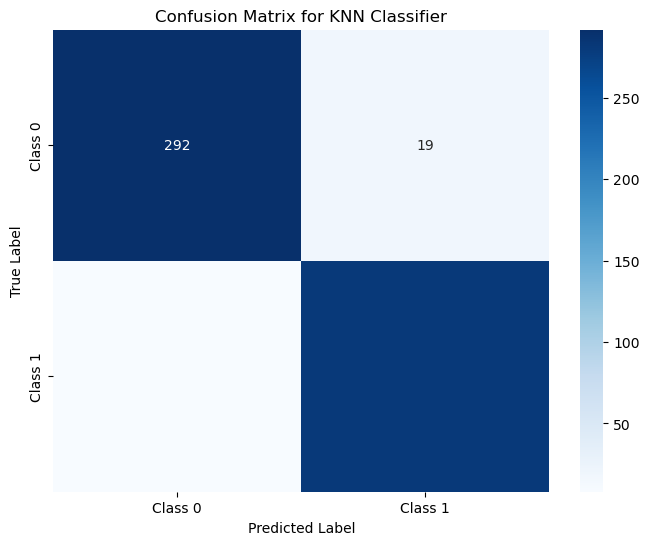

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are the arrays containing your model predictions and actual labels

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for KNN Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [28]:
## SVM

x, x_test, y, y_test = train_test_split(
    data, label, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.25, random_state=1)

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['rbf']
}
split_index = [-1 if x in range(len(x_train)) else 0 for x in range(len(x))]
ps = PredefinedSplit(test_fold=split_index)
svm_clf = GridSearchCV(SVC(), param_grid, cv=ps, refit=True)
svm_clf.fit(x, y)

svm_pred = svm_clf.predict(x_test)
# y_pred = svm_clf.predict(x_test)
y_true = y_test

print(metrics.classification_report(y_true, y_pred))
print(metrics.confusion_matrix(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# predict_and_plot(svm_clf, x_val, y_val)

              precision    recall  f1-score   support

       False       0.94      0.94      0.94       311
        True       0.94      0.93      0.93       289

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600

[[293  18]
 [ 20 269]]
Accuracy: 0.9366666666666666


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

# Assume y_test, knn_pred_test, svm_pred_test, ensemble_pred_test, rf_pred_test are defined from model predictions

# List of model predictions and labels for plotting
model_predictions = [
    (y_pred, "KNN"),
    (svm_pred, "SVM"),
    # (ensemble_pred_test, "Ensemble"),
    # Uncomment the next line if Random Forest predictions are available
    # (rf_pred_test, "Random Forest")
]

# Define class names if they are not straightforward (replace 'class_labels' with actual names if necessary)
class_names = ['Stressed', 'Not Stressed']  # Adjust according to your classification labels

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name, classes, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f'{title} for {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Loop through all models and plot their confusion matrices
for predictions, model_name in model_predictions:
    cm = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cm, model_name, class_names)


ValueError: Found input variables with inconsistent numbers of samples: [600, 10]

In [7]:
from sklearn.ensemble import VotingClassifier

# Assuming knn_clf and svm_clf are already trained models

# Create a Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('knn', knn_clf),
    ('svm', svm_clf)
], voting='hard')  # 'hard' voting means majority class wins

# Train the ensemble model
voting_clf.fit(x, y)

# Make predictions on the test set
y_pred_ensemble = voting_clf.predict(x_test)

# Evaluate the ensemble model
print("Ensemble Model:")
print(metrics.classification_report(y_true, y_pred_ensemble))
print(metrics.confusion_matrix(y_true, y_pred_ensemble))

accuracy_ensemble = accuracy_score(y_true, y_pred_ensemble)
print("Accuracy:", accuracy_ensemble)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.

Ensemble Model:
              precision    recall  f1-score   support

       False       0.93      0.98      0.95       311
        True       0.98      0.92      0.95       289

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

[[306   5]
 [ 24 265]]
Accuracy: 0.9516666666666667


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import numpy as np

# Assuming data and label are your features and labels

# Split the data into training, validation, and test sets
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=1)

# Scale the data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

# Train KNN model
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(x_train_scaled, y_train)

# Get KNN predictions for training and validation sets
knn_train_predictions = knn_clf.predict(x_train_scaled)
knn_val_predictions = knn_clf.predict(x_val_scaled)

# Add KNN predictions as features for training the SVM model
x_train_combined = np.column_stack((x_train_scaled, knn_train_predictions))
x_val_combined = np.column_stack((x_val_scaled, knn_val_predictions))

# Train SVM model
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['rbf']}
split_index_svm = [-1] * len(x_train_combined) + [0] * len(x_val_combined)
ps_svm = PredefinedSplit(test_fold=split_index_svm)
svm_clf = GridSearchCV(SVC(), param_grid_svm, cv=ps_svm, refit=True)
svm_clf.fit(np.vstack((x_train_combined, x_val_combined)), np.concatenate((y_train, y_val)))

# Get SVM predictions on the test set
svm_test_predictions = svm_clf.predict(np.column_stack((x_test_scaled, knn_clf.predict(x_test_scaled))))

# Evaluate the SVM model
print("SVM Model:")
print(classification_report(y_test, svm_test_predictions))
print(confusion_matrix(y_test, svm_test_predictions))
accuracy_svm = accuracy_score(y_test, svm_test_predictions)
print("Accuracy:", accuracy_svm)




NameError: name 'data' is not defined

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Split the data into train and test sets
x, x_test, y, y_test = train_test_split(
    data, label, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.25, random_state=1)

# Define hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define PredefinedSplit
split_index = [-1 if x in range(len(x_train)) else 0 for x in range(len(x))]
ps = PredefinedSplit(test_fold=split_index)

# Create GridSearchCV instance for Decision Tree
dt_clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=ps, refit=True)

# Train the Decision Tree classifier
dt_clf.fit(x, y)

# Make predictions on the test set
y_pred = dt_clf.predict(x_test)
y_true = y_test

# Print classification report and confusion matrix
print(metrics.classification_report(y_true, y_pred))
print(metrics.confusion_matrix(y_true, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)




              precision    recall  f1-score   support

       False       0.74      0.79      0.77       311
        True       0.76      0.70      0.73       289

    accuracy                           0.75       600
   macro avg       0.75      0.75      0.75       600
weighted avg       0.75      0.75      0.75       600

[[247  64]
 [ 86 203]]
Accuracy: 0.75


In [56]:


from sklearn.ensemble import RandomForestClassifier

# Split the data into train and test sets
x, x_test, y, y_test = train_test_split(
    data, label, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.25, random_state=1)

# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define PredefinedSplit
split_index = [-1 if x in range(len(x_train)) else 0 for x in range(len(x))]
ps = PredefinedSplit(test_fold=split_index)

# Create GridSearchCV instance for Random Forest
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=ps, refit=True)

# Train the Random Forest classifier
rf_clf.fit(x, y)

# Make predictions on the test set
y_pred = rf_clf.predict(x_test)
y_true = y_test

# Print classification report and confusion matrix
print(metrics.classification_report(y_true, y_pred))
print(metrics.confusion_matrix(y_true, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


KeyboardInterrupt: 

# Modified Code - Added other models


Accuracy: 51.83%
F1 Score: 0.62
Accuracy: 57.00%
F1 Score: 0.36
Accuracy: 58.33%
F1 Score: 0.38
Accuracy: 56.83%
F1 Score: 0.60
Accuracy: 56.50%
F1 Score: 0.59
Accuracy: 62.17%
F1 Score: 0.56
Accuracy: 63.17%
F1 Score: 0.62
Accuracy: 62.33%
F1 Score: 0.61
Accuracy: 63.17%
F1 Score: 0.63
Test Set Accuracy: 60.83%
Validation Set Accuracy: 63.17%
Accuracy: 63.17%
F1 Score: 0.63
0.6996336996336996
0.5787878787878787
AUC Score:0.64


array([False,  True, False,  True,  True, False, False, False, False,
        True,  True,  True,  True, False, False, False,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True, False,  True, False,  True,
       False, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
       False,  True,  True, False, False,  True, False, False,  True,
       False,  True,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True, False,  True,  True, False, False,  True, False, False,
       False,  True, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,

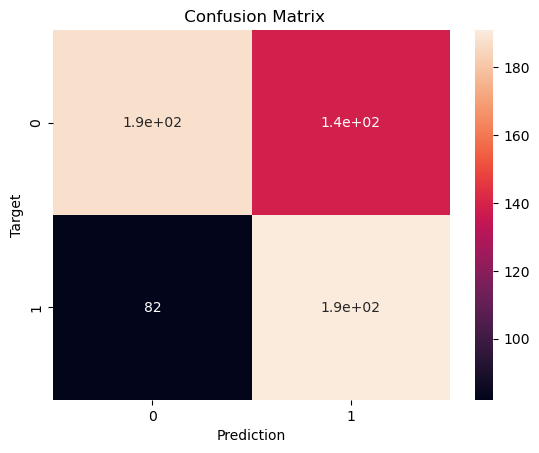

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


######## DECISION TREE

x, x_test, y, y_test = train_test_split(
    data, label, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.25, random_state=1)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


# Initialize Decision Tree Classifier
acc=[]
f1_list=[]
for i in range(1,10) :
    dt_clf = DecisionTreeClassifier(random_state=1, max_depth = i)

# Train the classifier on the training data
    dt_clf.fit(x_train, y_train)
    
    preds = dt_clf.predict(x_val)
    probs = dt_clf.predict_proba(x_val)
    accuracy = accuracy_score(y_val, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    acc.append(accuracy)
    f1 = f1_score(y_val,preds)
    f1_list.append(f1)
    print("F1 Score: {:.2f}".format(f1))



# Predict on the validation set
y_val_pred = dt_clf.predict(x_val)

# Predict on the test set
y_test_pred = dt_clf.predict(x_test)



# Predict on the validation set
y_val_pred = dt_clf.predict(x_val)

# Predict on the test set
y_test_pred = dt_clf.predict(x_test)

# Calculate accuracy on the test set
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")

# Calculate accuracy on the validation set
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
print(f"Validation Set Accuracy: {val_accuracy * 100:.2f}%")

predict_and_plot(dt_clf, x_val, y_val)

In [10]:
########### KNN
import matplotlib.pyplot as plt


# Initialize KNN Classifier
acc=[]
f1_list=[]
for i in range(1,5) :
    knn_clf = KNeighborsClassifier(n_neighbors=i)
    knn_clf.fit(x_train, y_train)
    
    preds = knn_clf.predict(x_val)
#     probs = dt_clf.predict_proba(x_val)
    accuracy = accuracy_score(y_val, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    acc.append(accuracy)
    f1 = f1_score(y_val,preds)
    f1_list.append(f1)
    print("F1 Score: {:.2f}".format(f1))

plt.plot(f1_list)
plt.plot(acc) 

predict_and_plot(knn_clf, x_val, y_val)

Accuracy: 94.50%


NameError: name 'f1_score' is not defined

In [11]:
def predict_and_plot(model, inputs, targets, name=''):
    preds = model.predict(inputs)
    probs = model.predict_proba(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    f1 = f1_score(targets,preds)
    print("F1 Score: {:.2f}".format(f1))
    recall = recall_score(targets,preds)
    print(recall)
    precision = precision_score(targets,preds)
    print(precision)
    auc = roc_auc_score(targets,preds)
    print("AUC Score:{:.2f}".format(auc))
    cf = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds


Accuracy (n_estimators=1): 56.17%
F1 Score (n_estimators=1): 0.52
Accuracy (n_estimators=2): 56.83%
F1 Score (n_estimators=2): 0.37
Accuracy (n_estimators=3): 59.33%
F1 Score (n_estimators=3): 0.55
Accuracy (n_estimators=4): 59.33%
F1 Score (n_estimators=4): 0.46
Accuracy (n_estimators=5): 61.50%
F1 Score (n_estimators=5): 0.59
Accuracy (n_estimators=6): 62.50%
F1 Score (n_estimators=6): 0.52
Accuracy (n_estimators=7): 63.83%
F1 Score (n_estimators=7): 0.61
Accuracy (n_estimators=8): 64.67%
F1 Score (n_estimators=8): 0.57
Accuracy (n_estimators=9): 65.83%
F1 Score (n_estimators=9): 0.63
Accuracy: 65.83%
F1 Score: 0.63
0.6336996336996337
0.6223021582733813
AUC Score:0.66


array([False, False,  True,  True,  True, False, False, False, False,
        True, False, False, False,  True, False, False,  True, False,
        True,  True,  True, False,  True, False, False,  True,  True,
        True, False,  True, False,  True, False,  True, False, False,
       False, False, False,  True, False,  True,  True, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True,  True,  True, False,  True,
       False,  True, False,  True,  True,  True, False,  True, False,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False, False,  True, False, False, False, False,
        True, False, False, False,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, False,  True, False,
        True,  True, False, False,  True,  True, False, False,  True,
       False,  True, False,  True, False, False, False,  True, False,
       False,  True,

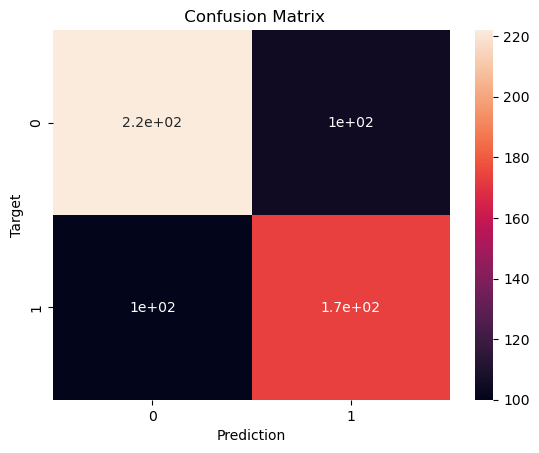

In [64]:
######### RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,recall_score
acc = []
f1_list = []

for i in range(1, 10):
    # Initialize Random Forest classifier with different number of trees
    rf_clf = RandomForestClassifier(n_estimators=i, random_state=42)
    
    # Train the Random Forest classifier
    rf_clf.fit(x_train, y_train)
    
    # Make predictions on the validation set
    preds = rf_clf.predict(x_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, preds)
    print("Accuracy (n_estimators={}): {:.2f}%".format(i, accuracy * 100))
    acc.append(accuracy)
    
    # Calculate F1 score
    f1 = f1_score(y_val, preds)
    f1_list.append(f1)
    print("F1 Score (n_estimators={}): {:.2f}".format(i, f1))
    
    
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score, roc_auc_score, confusion_matrix
import seaborn as sns

predict_and_plot(rf_clf, x_val, y_val)

# predict_and_plot(knn_clf, x_val, y_val)

Accuracy: 100.00%
F1 Score: 1.00
1.0
1.0
AUC Score:1.00


array([False,  True,  True, False,  True, False, False, False,  True,
        True, False, False, False, False, False, False,  True, False,
        True, False,  True, False, False, False,  True,  True,  True,
        True, False, False, False,  True, False,  True, False, False,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False, False, False, False,  True,  True, False, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False,  True,  True, False, False,
       False, False, False,  True, False,  True, False,  True,  True,
       False, False,  True,  True, False,  True, False,  True, False,
       False,  True, False, False, False,  True, False,  True, False,
       False,  True,  True, False,  True,  True, False, False,  True,
       False,  True,

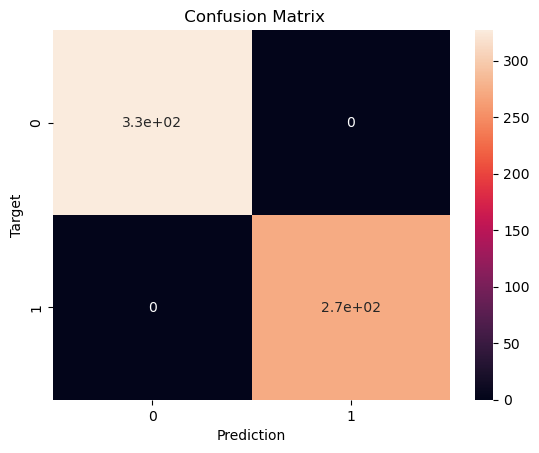

In [37]:
predict_and_plot(knn_clf, x_val, y_val)

# Multilayer Perceptron

In [32]:
K.clear_session()
y_v = label
y_v = to_categorical(y_v)
x_train, x_test, y_train, y_test = train_test_split(
    data, y_v, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.25, random_state=1)


In [33]:
from keras.optimizers import Adam as LegacyAdam  # Import the legacy Adam optimizer

def model_builder(hp):
    model = models.Sequential()
    model.add(Input(shape=(x_train.shape[1],)))

    for i in range(hp.Int('layers', 2, 6)):
        model.add(Dense(units=hp.Int('units_' + str(i), 32, 1024, step=32),
                        activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))

    model.add(Dense(v.N_CLASSES, activation='softmax', name='out'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=LegacyAdam(learning_rate=hp_learning_rate),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    return model

In [34]:
tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=2,
    overwrite=True
)


In [35]:
tuner.search(x_train, y_train, epochs=50, validation_data=[x_val, y_val])

Trial 15 Complete [00h 00m 09s]
val_accuracy: 0.8675000071525574

Best val_accuracy So Far: 0.92166668176651
Total elapsed time: 00h 05m 16s


In [36]:
model = tuner.get_best_models(num_models=1)[0]

In [37]:
y_pred = model.predict(x_test)
y_true = y_test
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

19/19 [==============================] - 0s 462us/step


In [38]:
print(metrics.classification_report(y_true, y_pred))
print(metrics.confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       311
           1       0.92      0.93      0.93       289

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

[[289  22]
 [ 20 269]]


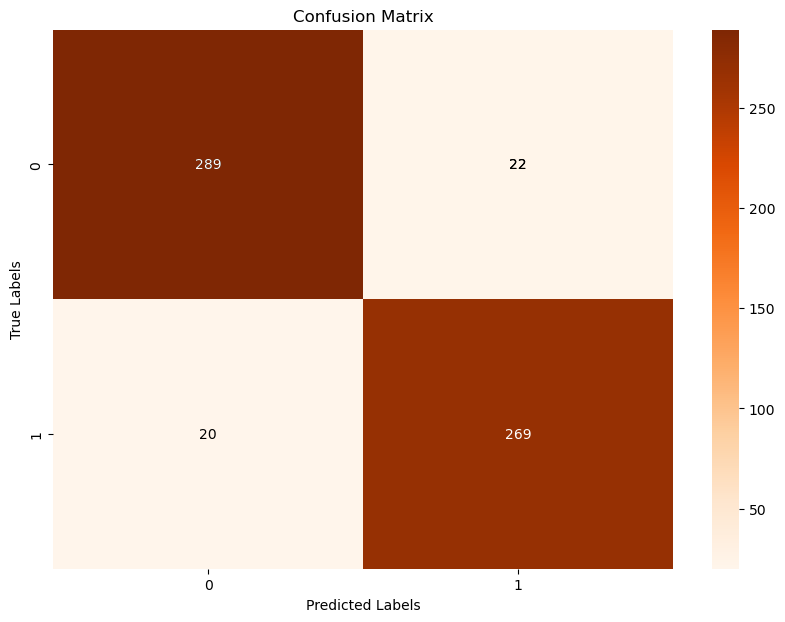

In [72]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix array
cm = np.array([[284, 18], [20, 288]])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))

# Use the 'annot_kws' parameter to set the text color based on the cell value
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Oranges', annot_kws={"color": "black", "ha": 'center'})

# Set a threshold for the text color contrast
threshold = cm_array.max() / 2.

# Change the color depending on the background
for i in range(cm_array.shape[0]):
    for j in range(cm_array.shape[1]):
        color = "white" if cm_array[i, j] > threshold else "black"
        plt.text(j+0.5, i+0.5, format(cm_array[i, j], 'd'),
                 horizontalalignment='center',
                 verticalalignment='center',
                 color=color)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [47]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Binarize the labels for the true test set labels
y_test_binarized = label_binarize(y_true, classes=np.arange(v.N_CLASSES))

# Predict class probabilities for the test set
y_probs = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(v.N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(v.N_CLASSES)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(v.N_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= v.N_CLASSES

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(v.N_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()


19/19 [==============================] - 0s 397us/step


ValueError: Found input variables with inconsistent numbers of samples: [600, 1200]

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'data' contains EEG signals and 'label' contains corresponding labels
# Ensure data is formatted properly as a 3D array (samples, height, width)
# For CNN, EEG signals might be represented as 2D images or spectrograms

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Define CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(data.shape[1], data.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output before feeding into fully connected layers
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer for regularization
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on test set
loss, accuracy = model.evaluate(x_test, y_test_categorical)
print('Test Accuracy:', accuracy)

# Predictions
y_pred_categorical = model.predict(x_test)
y_pred = np.argmax(y_pred_categorical, axis=1)

# Decode one-hot encoded labels back to original labels
y_test_decoded = label_encoder.inverse_transform(np.argmax(y_test_categorical, axis=1))

# Generate classification report and confusion matrix
print(classification_report(y_test_decoded, label_encoder.inverse_transform(y_pred)))
print(confusion_matrix(y_test_decoded, label_encoder.inverse_transform(y_pred)))


IndexError: tuple index out of range

In [34]:
print("Shape of data:", data.shape)


Shape of data: (3000, 96)


In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'data' contains EEG signals and 'label' contains corresponding labels
# Ensure data is formatted properly as a 3D array (samples, timesteps, features)
# For RNN, EEG signals might be represented as sequences of data points

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

# Define RNN model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=64, input_shape=(data.shape[1], data.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout for regularization

# Add another LSTM layer
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(x_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on test set
loss, accuracy = model.evaluate(x_test, y_test_categorical)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Generate predictions
y_pred_categorical = model.predict(x_test)
y_pred = np.argmax(y_pred_categorical, axis=1)

# Decode one-hot encoded labels back to original labels
y_test_decoded = label_encoder.inverse_transform(np.argmax(y_test_categorical, axis=1))

# Generate classification report and confusion matrix
print(classification_report(y_test_decoded, label_encoder.inverse_transform(y_pred)))
print(confusion_matrix(y_test_decoded, label_encoder.inverse_transform(y_pred)))


IndexError: tuple index out of range

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                3104      
                                                                 
 dense_20 (Dense)            (None, 64)                2112      
                                                                 
 dense_21 (Dense)            (None, 10)                650       
                                                                 
Total params: 5866 (22.91 KB)
Trainable params: 5866 (22.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               8320      
                                                              

ValueError: in user code:

    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 64), found shape=(None, 96)


In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'data' contains EEG signals and 'label' contains corresponding labels
# Ensure data is formatted properly as a 4D array (samples, height, width, channels)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

# Define CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(x_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on test set
loss, accuracy = model.evaluate(x_test, y_test_categorical)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Generate predictions
y_pred_categorical = model.predict(x_test)
y_pred = np.argmax(y_pred_categorical, axis=1)

# Decode one-hot encoded labels back to original labels
y_test_decoded = label_encoder.inverse_transform(np.argmax(y_test_categorical, axis=1))

# Generate classification report and confusion matrix
print(classification_report(y_test_decoded, label_encoder.inverse_transform(y_pred)))
print(confusion_matrix(y_test_decoded, label_encoder.inverse_transform(y_pred)))


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_14 (Dense)            (None, 128)              

ValueError: in user code:

    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 64, 64, 1), found shape=(None, 96)


In [28]:
data = data.reshape(3000,64)


ValueError: cannot reshape array of size 288000 into shape (3000,64)

# import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'data' contains reshaped EEG signals and 'label' contains corresponding labels
# Ensure data is formatted properly as a 4D array (samples, height, width, channels)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(np.unique(label))
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Define CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(x_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on test set
loss, accuracy = model.evaluate(x_test, y_test_categorical)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Generate predictions
y_pred_categorical = model.predict(x_test)
y_pred = np.argmax(y_pred_categorical, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [26]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create a sequential model
model = Sequential()

# Add the first layer with the adjusted input shape
model.add(Dense(32, activation='relu', input_shape=(96,)))  # Adjust input_shape to match the shape of your input data

# Add more layers as needed
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model and specify loss function, optimizer, etc.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()Output 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                3104      
                                                                 
 dense_17 (Dense)            (None, 64)                2112      
                                                                 
 dense_18 (Dense)            (None, 10)                650       
                                                                 
Total params: 5866 (22.91 KB)
Trainable params: 5866 (22.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'data' contains EEG signals and 'label' contains corresponding labels
# Ensure data is formatted properly as a 2D array (samples, features)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

# Define DNN model
model = Sequential()

# Add Dense layers with ReLU activation
model.add(Dense(128, activation='relu', input_shape=(64,)))
model.add(Dropout(0.5))  # Dropout layer for regularization
model.add(Dense(64, activation='relu'))

# Add output layer with softmax activation for classification
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(x_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on test set
loss, accuracy = model.evaluate(x_test, y_test_categorical)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Generate predictions
y_pred_categorical = model.predict(x_test)
y_pred = np.argmax(y_pred_categorical, axis=1)

# Decode one-hot encoded labels back to original labels
y_test_decoded = label_encoder.inverse_transform(np.argmax(y_test_categorical, axis=1))

# Generate classification report and confusion matrix
print(classification_report(y_test_decoded, label_encoder.inverse_transform(y_pred)))
print(confusion_matrix(y_test_decoded, label_encoder.inverse_transform(y_pred)))


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 2)                 130       
                                                                 
Total params: 16706 (65.26 KB)
Trainable params: 16706 (65.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


ValueError: in user code:

    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Anaconda\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 64), found shape=(None, 96)
